## Dominant-hand filtering and technique-specific blanking for `data.csv`

This notebook:
1. Loads `data.csv`.
2. Infers each participant's dominant hand via paired t-tests on left/right metrics.
3. Blanks the non-dominant hand measurements (per participant) and blanks columns by technique.
4. Drops unnamed columns left over from CSV export.
5. Runs recursive feature elimination (RFE, sklearn equivalent of R caret) with linear regression.


In [329]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

raw_path = "data_w_time.csv"
df = pd.read_csv(raw_path)
print(f"Loaded {len(df)} rows and {df.shape[1]} columns from {raw_path}")
df.head()

Loaded 480 rows and 33 columns from data_w_time.csv


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Metrics used to infer dominance
We test the mean difference between left and right values for the following pairs (paired t-test, alpha=0.05):
- Total distance
- Extent
- Thumbstick distance and extent
- Trigger pressure
- Grip pressure
- Head distance


In [330]:
hand_pairs = [
    ("leftTotalDistance", "rightTotalDistance", "totalDistance"),
    ("leftExtent", "rightExtent", "extent"),
    ("leftThumbstickDistance", "rightThumbstickDistance", "thumbstickDistance"),
    ("leftThumbstickExtent", "rightThumbstickExtent", "thumbstickExtent"),
    ("leftTriggerPressure", "rightTriggerPressure", "triggerPressure"),
    ("leftGripPressure", "rightGripPressure", "gripPressure"),
    ("leftHeadDistance", "rightHeadDistance", "headDistance"),
]

alpha = 0.05

def infer_dominant_hand(frame, pairs, alpha=0.05):
    dominant = {}
    rows = []
    for pid, group in frame.groupby("iD"):
        votes = []
        for left, right, label in pairs:
            cols = group[[left, right]].dropna()
            if len(cols) < 2:
                continue
            stat, p = ttest_rel(cols[left], cols[right])
            if np.isnan(p):
                continue
            mean_diff = cols[right].mean() - cols[left].mean()
            if p < alpha:
                votes.append(np.sign(mean_diff))
            rows.append({
                "iD": pid,
                "metric": label,
                "left_mean": cols[left].mean(),
                "right_mean": cols[right].mean(),
                "mean_diff": mean_diff,
                "p_value": p,
            })
        if votes:
            score = np.sign(np.sum(votes))
            if score > 0:
                dominant[pid] = "Right"
            elif score < 0:
                dominant[pid] = "Left"
            else:
                dominant[pid] = "Ambiguous"
        else:
            dominant[pid] = "Ambiguous"
    detail_df = pd.DataFrame(rows)
    return dominant, detail_df


In [331]:
dominant_map, ttest_details = infer_dominant_hand(df, hand_pairs, alpha)
dominant_hand_series = df["iD"].map(dominant_map)

print("Dominant hand per participant (computed, not added to dataset):")
dominant_hand_overview = pd.DataFrame(
    sorted(dominant_map.items()), columns=["iD", "dominant_hand"]
)
print(dominant_hand_overview)
print("\nSample of t-test details (per participant x metric):")
display(ttest_details.head())


Dominant hand per participant (computed, not added to dataset):
      iD dominant_hand
0   P001          Left
1   P002         Right
2   P003         Right
3   P004         Right
4   P005         Right
..   ...           ...
64  P065          Left
65  P066     Ambiguous
66  P067     Ambiguous
67  P068     Ambiguous
68  P069     Ambiguous

[69 rows x 2 columns]

Sample of t-test details (per participant x metric):


/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,iD,metric,left_mean,right_mean,mean_diff,p_value
0,P001,totalDistance,1.508333,0.333333,-1.175000,0.009660
1,P001,extent,0.555000,0.153333,-0.401667,0.011783
2,P001,thumbstickDistance,0.560000,0.090000,-0.470000,0.187298
3,P001,thumbstickExtent,0.283333,0.065000,-0.218333,0.060078
4,P001,triggerPressure,0.323333,0.050000,-0.273333,0.115924


In [332]:
skip_feature_engineering = True  # set to False to re-enable feature blanking

clean_df = df.copy()
right_mask = dominant_hand_series == "Right"
left_mask = dominant_hand_series == "Left"

if not skip_feature_engineering:
    for left, right, _ in hand_pairs:
        clean_df.loc[right_mask, left] = np.nan
        clean_df.loc[left_mask, right] = np.nan
    print("Applied dominant-hand blanking.")
else:
    print("Skipping dominant-hand blanking; keeping raw features.")

clean_df.head()


Skipping dominant-hand blanking; keeping raw features.


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Technique-specific blanking
- `Chicken`: blank all hand-related columns (left/right position, thumbstick, trigger/grip, and head-distance-by-hand) and corresponding `dominant_*` hand columns.
- `Astral`, `Grab`, `Sliding`, `Teleport`, `Throw`: blank head-related columns and `dominant_headDistance`.


In [333]:
hand_cols = [
    "leftTotalDistance", "rightTotalDistance",
    "leftExtent", "rightExtent",
    "leftHeadDistance", "rightHeadDistance",
    "leftThumbstickDistance", "rightThumbstickDistance",
    "leftThumbstickExtent", "rightThumbstickExtent",
    "leftTriggerPressure", "rightTriggerPressure",
    "leftGripPressure", "rightGripPressure",
]

head_cols = ["headTotalDistance", "headExtent"]

if not skip_feature_engineering:
    chicken_mask = clean_df["technique"] == "Chicken"
    clean_df.loc[chicken_mask, hand_cols] = np.nan

    head_mask = clean_df["technique"].isin(["Astral", "Grab", "Sliding", "Teleport", "Throw"])
    clean_df.loc[head_mask, head_cols] = np.nan

    print("Applied technique-specific blanking:")
    print(f"Hand columns blanked for Chicken rows: {chicken_mask.sum()} rows")
    print(f"Head columns blanked for Astral/Grab/Sliding/Teleport/Throw rows: {head_mask.sum()} rows")
else:
    print("Skipping technique-specific blanking; keeping all features.")

clean_df.head()


Skipping technique-specific blanking; keeping all features.


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [334]:
# Drop unnamed columns created by CSV export artifacts
unnamed_cols = [c for c in clean_df.columns if c.lower().startswith("unnamed")]
if unnamed_cols:
    clean_df = clean_df.drop(columns=unnamed_cols)
    print(f"Dropped {len(unnamed_cols)} unnamed column(s): {unnamed_cols}")
else:
    print("No unnamed columns to drop.")
clean_df.head()

Dropped 7 unnamed column(s): ['Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32']


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,rightThumbstickExtent,leftTriggerPressure,rightTriggerPressure,leftGripPressure,rightGripPressure,buttonPressCount,movementVariability,targetEnteredCount,axisCrossedCount,trialTime
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,0.05,0.05,0.02,0.03,0.01,20.0,0.90,13.0,22.0,12.76
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,0.04,0.00,0.00,0.00,0.00,0.0,0.95,11.0,20.0,21.12
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,0.06,0.80,0.10,0.20,0.05,6.0,1.05,14.0,28.0,15.12
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,0.06,0.06,0.02,0.05,0.02,38.0,0.92,13.0,24.0,16.14
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,0.08,0.85,0.10,0.12,0.04,18.0,1.00,15.0,30.0,13.20


### Target distribution & optional log transform
- Plot histogram of `trialTime`.
- If skewness > 1 (long tail), apply log1p transform to create `trialTime_log` and use it as the modeling target.


Target skewness = 1.28; applying log1p -> column 'trialTime_log'.


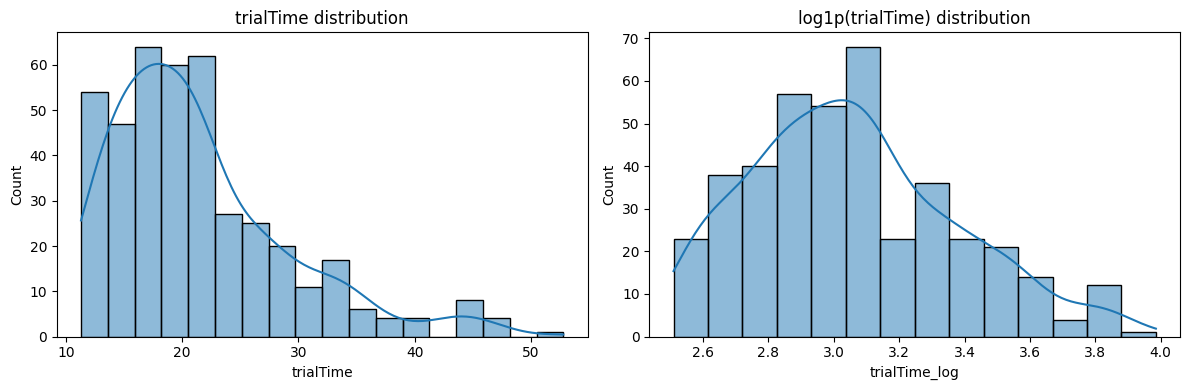

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

target_raw = clean_df["trialTime"].dropna()
skew_val = target_raw.skew()
log_transform = skew_val > 1.0

target_col_name = "trialTime"
if log_transform:
    target_col_name = "trialTime_log"
    clean_df[target_col_name] = np.log1p(clean_df["trialTime"])
    print(f"Target skewness = {skew_val:.2f}; applying log1p -> column '{target_col_name}'.")
else:
    print(f"Target skewness = {skew_val:.2f}; no log transform applied.")

fig, axes = plt.subplots(1, 2 if log_transform else 1, figsize=(12, 4))
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

sns.histplot(target_raw, kde=True, ax=axes[0])
axes[0].set_title("trialTime distribution")
axes[0].set_xlabel("trialTime")

if log_transform:
    sns.histplot(clean_df[target_col_name].dropna(), kde=True, ax=axes[1])
    axes[1].set_title("log1p(trialTime) distribution")
    axes[1].set_xlabel(target_col_name)

plt.tight_layout()
plt.show()


### CV splitter helper
- Use stratified K-fold on binned target (regression) with shuffle to ensure randomness.


In [336]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

# Toggle to include/exclude time-related columns from the feature set
include_time_features = True

def select_base_features(df, target_col, extra_drop=None):
    drop_cols = [target_col, "iD", "technique"]
    if extra_drop:
        drop_cols.extend(extra_drop)
    if not include_time_features:
        drop_cols.extend([c for c in df.columns if "time" in c.lower()])
    drop_set = set(drop_cols)
    return [c for c in df.columns if c not in drop_set]

def get_stratified_cv(y, n_splits=3, random_state=42):
    # Bin targets for stratification; duplicates='drop' handles small unique counts
    bins = pd.qcut(y, q=min(5, len(y)), duplicates='drop').astype(str)  # cast intervals to labels for sklearn
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return list(skf.split(np.zeros(len(y)), bins))

def get_feature_names(preprocessor):
    """Return feature names from a fitted ColumnTransformer."""
    try:
        return preprocessor.get_feature_names_out()
    except Exception:
        feature_names = []
        for name, transformer, cols in preprocessor.transformers_:
            if name == "remainder":
                continue
            current_cols = list(cols)
            fitted = transformer
            if isinstance(transformer, Pipeline):
                fitted = transformer.steps[-1][1]
            if hasattr(fitted, "get_feature_names_out"):
                try:
                    names = fitted.get_feature_names_out(current_cols)
                except TypeError:
                    names = fitted.get_feature_names_out()
            else:
                names = current_cols
            feature_names.extend(names)
        return feature_names

def extract_feature_importances(search, model_key):
    """Extract a DataFrame of feature importances from a fitted GridSearchCV pipeline."""
    model = search.best_estimator_.named_steps[model_key]
    importances = getattr(model, "feature_importances_", None)
    if importances is None:
        return None
    preprocessor = search.best_estimator_.named_steps["prep"]
    feature_names = get_feature_names(preprocessor)
    return (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )


### 特征选择：递归特征消除（RFE） + 线性回归
- 使用 sklearn 的 `RFE`（对应 R 中 caret 的 RFE 功能）并选择线性回归作为估计器。
- 目标变量：`trialTime`（或 log 变换后的 `trialTime_log`，由上方直方图单元自动决定）；去除标识列 `iD`，对分类特征做 one-hot 编码。
- 对清洗后产生的缺失值使用列中位数填充，以便模型训练。


In [337]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

use_feature_selection = False  # toggle: True = RFE-selected features, False = use all features

# Prepare data for RFE / linear regression
target_col = target_col_name
model_df = clean_df.dropna(subset=[target_col]).copy()

feature_cols = [c for c in model_df.columns if c not in [target_col, "iD"]]
feature_df = pd.get_dummies(model_df[feature_cols], drop_first=True)

# Fill blanks introduced by earlier cleaning with the median per column
feature_df = feature_df.apply(lambda col: col.fillna(col.median()))

X = feature_df.values
y = model_df[target_col].values

if use_feature_selection:
    n_features = min(10, X.shape[1])  # keep top 10 features (or fewer if not available)
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
    rfe.fit(X, y)

    selected_features = feature_df.columns[rfe.support_]
    ranking_df = pd.DataFrame(
        {"feature": feature_df.columns, "rank": rfe.ranking_, "selected": rfe.support_}
    ).sort_values(by=["rank", "feature"])

    X_selected = rfe.transform(X)
    lin = rfe.estimator_
    lin.fit(X_selected, y)
    r2 = lin.score(X_selected, y)

    print(f"[RFE ON] Selected top {len(selected_features)} of {feature_df.shape[1]} features to predict {target_col}.")
    print(f"Training R^2 using selected features: {r2:.3f}")
    display(pd.DataFrame(selected_features, columns=["selected_feature"]))
    display(ranking_df.head(20))
else:
    lin = LinearRegression()
    lin.fit(X, y)
    r2 = lin.score(X, y)
    print(f"[RFE OFF] Using all {feature_df.shape[1]} features to predict {target_col}.")
    print(f"Training R^2 using all features: {r2:.3f}")


[RFE OFF] Using all 28 features to predict trialTime_log.
Training R^2 using all features: 0.970


In [338]:
clean_path = "data_cleaned.csv"
clean_df.to_csv(clean_path, index=False)
print(f"Saved cleaned data to {clean_path} after dropping unnamed columns.")

Saved cleaned data to data_cleaned.csv after dropping unnamed columns.


## 通用模型：Technique ID + LOGO（随机森林）
- 在特征中保留 `technique` 并做 One-Hot，显式告诉模型当前技术（Technique ID）。
- 目标：通用模型，可接收任意用户 + 技术组合，预测完成时间（默认使用上面选择的目标列）。
- 数据拆分：`Leave-One-Group-Out`，group=`iD`，检验新用户场景下的泛化。
- 模型：`RandomForestRegressor`（适度限制叶子数避免过拟合）。
- `cross_validate` 自动循环 LOGO 折并汇总每个被留出的用户的 R² / MAE。


In [339]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

logo_df = clean_df.dropna(subset=[target_col_name]).reset_index(drop=True)
groups = logo_df["iD"]

# 保留 technique 作为显式特征；去掉目标列、原始时间列、用户 ID
exclude_cols = {"iD", "trialTime", "trialTime_log", target_col_name}
feature_cols = [c for c in logo_df.columns if c not in exclude_cols]
X = logo_df[feature_cols].copy()
y = logo_df[target_col_name].copy()

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocessor = ColumnTransformer(
    [
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_cols,
        ),
    ]
)

rf_logo = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)

logo_pipeline = Pipeline([("prep", preprocessor), ("rf", rf_logo)])

logo = LeaveOneGroupOut()
logo_splits = list(logo.split(X, y, groups))
scoring = {"r2": "r2", "neg_mae": "neg_mean_absolute_error"}

logo_cv = cross_validate(
    logo_pipeline,
    X,
    y,
    cv=logo_splits,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1,
)

held_out_ids = [groups.iloc[test_idx].unique()[0] for _, test_idx in logo_splits]
logo_summary = pd.DataFrame(
    {
        "held_out_iD": held_out_ids,
        "r2": logo_cv["test_r2"],
        "mae": -logo_cv["test_neg_mae"],
    }
).sort_values("held_out_iD").reset_index(drop=True)

print("LOGO Random Forest (with technique one-hot) - hold out each participant:")
display(logo_summary)
print("\nAverage performance across LOGO splits:")
display(logo_summary[["r2", "mae"]].mean().to_frame(name="mean").T)


def extract_pipeline_feature_importances(pipe, model_key="rf"):
    reg = pipe.named_steps.get(model_key)
    prep = pipe.named_steps.get("prep")
    if reg is None or not hasattr(reg, "feature_importances_") or prep is None:
        return None
    feature_names = prep.get_feature_names_out()
    return pd.DataFrame({"feature": feature_names, "importance": reg.feature_importances_})


fi_parts = []
for est in logo_cv["estimator"]:
    fi_df = extract_pipeline_feature_importances(est, "rf")
    if fi_df is not None:
        fi_parts.append(fi_df)

if fi_parts:
    fi_mean = pd.concat(fi_parts, ignore_index=True).groupby("feature")["importance"].mean().reset_index()
    top_fi = fi_mean.sort_values("importance", ascending=False).head(15)
    print("Top averaged feature importances across LOGO splits:")
    display(top_fi)

LOGO Random Forest (with technique one-hot) - hold out each participant:


,held_out_iD,r2,mae
0,P001,0.754308,0.076436
1,P002,-0.245539,0.204738
2,P003,0.717677,0.089130
3,P004,-0.068263,0.159129
4,P005,0.094462,0.223779
...,...,...,...
64,P065,0.443699,0.088534
65,P066,0.710610,0.102899
66,P067,-0.047865,0.236287
67,P068,-0.383736,0.205841



Average performance across LOGO splits:


,r2,mae
mean,-0.127718,0.18874


Top averaged feature importances across LOGO splits:


,feature,importance
10,num__headTotalDistance,0.093190
9,num__headExtent,0.091004
27,num__trial,0.077582
18,num__movementVariability,0.059042
12,num__leftGripPressure,0.057021
20,num__rightGripPressure,0.051258
7,num__axisCrossedCount,0.046752
21,num__rightHeadDistance,0.046689
8,num__buttonPressCount,0.040182
17,num__leftTriggerPressure,0.038487


### LOGO 随机森林结果可视化
- 按被留出的用户（iD）展示 R² / MAE 柱状图，查看哪些用户更难预测。
- 右侧给出整体分布（直方图 + MAE vs R² 散点），快速查看模型总体表现区间。


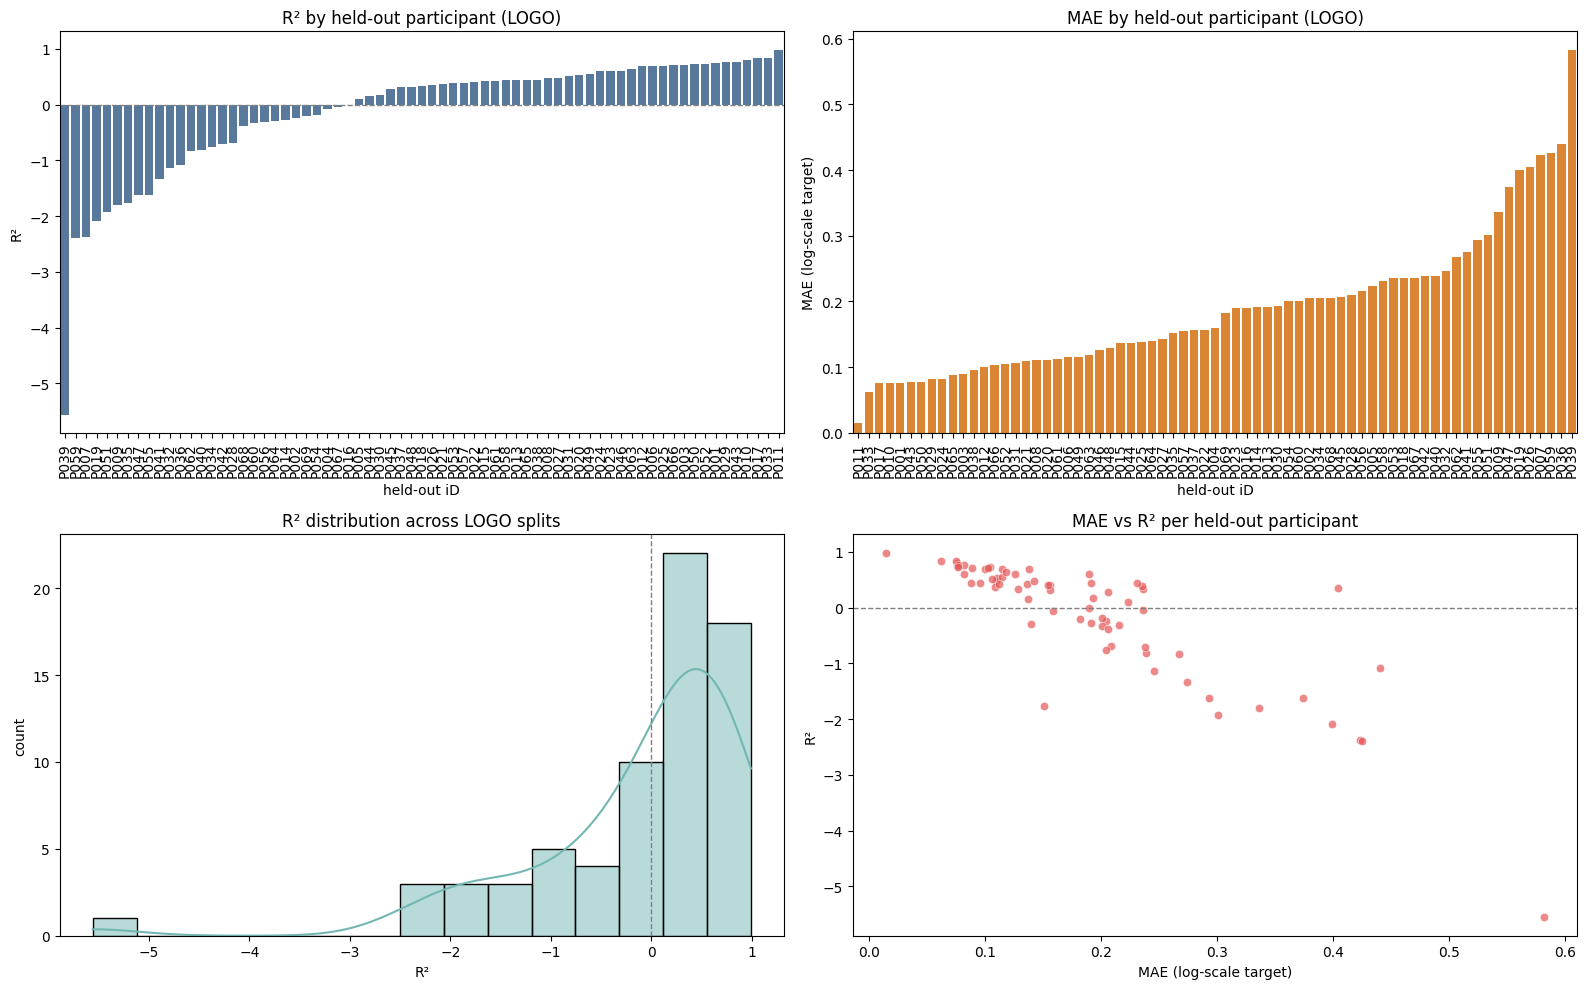

In [340]:
import seaborn as sns
import matplotlib.pyplot as plt

# 排序方便对比（R² 从低到高，MAE 从低到高）
r2_order = logo_summary.sort_values("r2")['held_out_iD']
mae_order = logo_summary.sort_values("mae")['held_out_iD']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.barplot(data=logo_summary, x="held_out_iD", y="r2", order=r2_order, ax=axes[0, 0], color="#4C78A8")
axes[0, 0].axhline(0, color="gray", linestyle="--", linewidth=1)
axes[0, 0].set_title("R² by held-out participant (LOGO)")
axes[0, 0].set_xlabel("held-out iD")
axes[0, 0].set_ylabel("R²")
axes[0, 0].tick_params(axis='x', rotation=90)

sns.barplot(data=logo_summary, x="held_out_iD", y="mae", order=mae_order, ax=axes[0, 1], color="#F58518")
axes[0, 1].set_title("MAE by held-out participant (LOGO)")
axes[0, 1].set_xlabel("held-out iD")
axes[0, 1].set_ylabel("MAE (log-scale target)")
axes[0, 1].tick_params(axis='x', rotation=90)

sns.histplot(data=logo_summary, x="r2", bins=15, kde=True, ax=axes[1, 0], color="#72B7B2")
axes[1, 0].axvline(0, color="gray", linestyle="--", linewidth=1)
axes[1, 0].set_title("R² distribution across LOGO splits")
axes[1, 0].set_xlabel("R²")
axes[1, 0].set_ylabel("count")

sns.scatterplot(data=logo_summary, x="mae", y="r2", ax=axes[1, 1], color="#E45756", alpha=0.7)
axes[1, 1].axhline(0, color="gray", linestyle="--", linewidth=1)
axes[1, 1].set_title("MAE vs R² per held-out participant")
axes[1, 1].set_xlabel("MAE (log-scale target)")
axes[1, 1].set_ylabel("R²")

plt.tight_layout()
plt.show()


## 校准技术预测（随机森林 + 交叉验证）
- 轮流将 Astral、Chicken、Grab、Sliding、Teleport、Throw 作为校准/hold-out：训练集 = 其他五种技术，测试集 = 当前校准技术。
- 目标：预测 hold-out 技术的 `trialTime`，移除 `technique` 列避免恒定列；丢弃当前训练集中全为空的列。
- 特征清洗：数值列中位数填充，类别列众数填充并独热编码。
- 模型：`RandomForestRegressor`，`GridSearchCV(cv=3)` 搜索 `n_estimators`、`max_depth`、`min_samples_leaf`、`max_features` 多组组合；记录每个校准技术的 R² 和 MAE，并保留逐条预测。

In [341]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

rf_results = []
prediction_rows = []
rf_cv_rows = []
rf_importance_rows = []

techniques = sorted(clean_df["technique"].dropna().unique())
target_col = target_col_name
base_feature_cols = select_base_features(clean_df, target_col)

rf_param_grid = {
    "rf__n_estimators": [200, 400, 800],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
}

for calibration_tech in techniques:
    train_df = clean_df[clean_df["technique"] != calibration_tech].dropna(subset=[target_col])
    test_df = clean_df[clean_df["technique"] == calibration_tech].dropna(subset=[target_col])

    usable_cols = [c for c in base_feature_cols if not train_df[c].isna().all()]
    X_train = train_df[usable_cols].copy()
    X_test = test_df[usable_cols].copy()
    y_train = train_df[target_col]
    cv_splits = get_stratified_cv(y_train, n_splits=3)
    y_test = test_df[target_col]

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    preprocessor = ColumnTransformer(
        [
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore")),
                    ]
                ),
                categorical_cols,
            ),
        ]
    )

    rf = RandomForestRegressor(random_state=42)
    model = Pipeline([("prep", preprocessor), ("rf", rf)])
    search = GridSearchCV(model, param_grid=rf_param_grid, cv=cv_splits, n_jobs=-1)
    search.fit(X_train, y_train)
    preds = search.predict(X_test)

    best_params = search.best_params_
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rf_results.append(
        {
            "calibration": calibration_tech,
            "r2": r2,
            "mae": mae,
            "best_n_estimators": best_params["rf__n_estimators"],
            "best_max_depth": best_params["rf__max_depth"],
            "best_min_samples_leaf": best_params["rf__min_samples_leaf"],
            "best_max_features": best_params["rf__max_features"],
        }
    )

    fi_df = extract_feature_importances(search, "rf")
    if fi_df is not None:
        rf_importance_rows.append(fi_df.assign(calibration=calibration_tech))

    cv_df = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv_df.columns if c.startswith("param_")]
    rf_cv_rows.append(cv_df[param_cols + ["mean_test_score"]].assign(calibration=calibration_tech))

    prediction_rows.append(
        pd.DataFrame(
            {
                "calibration": calibration_tech,
                "technique": test_df["technique"].values,
                "iD": test_df["iD"].values,
                "actual": y_test.values,
                "predicted": preds,
            }
        )
    )

rf_summary = pd.DataFrame(rf_results).sort_values("calibration").reset_index(drop=True)
rf_predictions = pd.concat(prediction_rows, ignore_index=True)
rf_cv_results = pd.concat(rf_cv_rows, ignore_index=True).assign(model="Random Forest")

print("Calibration hold-out Random Forest with CV (train on other five techniques):")
display(rf_summary)

if rf_importance_rows:
    rf_feature_importances = pd.concat(rf_importance_rows, ignore_index=True)
    print("Top RF feature importances (per calibration):")
    display(
        rf_feature_importances
        .sort_values(["calibration", "importance"], ascending=[True, False])
        .groupby("calibration")
        .head(15)
        .reset_index(drop=True)
    )

print("Prediction sample:")
display(rf_predictions.head())


Calibration hold-out Random Forest with CV (train on other five techniques):


,calibration,r2,mae,best_n_estimators,best_max_depth,best_min_samples_leaf,best_max_features
0,Astral,0.997384,0.008663,400,NaN,2,None
1,Chicken,0.994672,0.006966,400,NaN,2,None
2,Grab,0.998872,0.006004,400,NaN,2,None
3,Sliding,0.998961,0.005266,200,NaN,2,None
4,Teleport,0.997534,0.009826,400,10.0,1,None
5,Throw,0.995656,0.009813,200,NaN,2,None


Top RF feature importances (per calibration):


,feature,importance,calibration
0,num__trialTime,0.999304,Astral
1,num__buttonPressCount,0.000064,Astral
2,num__headTotalDistance,0.000052,Astral
3,num__leftGripPressure,0.000051,Astral
4,num__headExtent,0.000045,Astral
...,...,...,...
85,num__axisCrossedCount,0.000062,Throw
86,num__rightGripPressure,0.000059,Throw
87,num__leftExtent,0.000057,Throw
88,num__rightThumbstickExtent,0.000054,Throw


Prediction sample:


,calibration,technique,iD,actual,predicted
0,Astral,Astral,P001,2.621766,2.629083
1,Astral,Astral,P002,2.533697,2.554559
2,Astral,Astral,P003,2.912351,2.903293
3,Astral,Astral,P004,2.847232,2.843118
4,Astral,Astral,P005,2.777576,2.769444


### 可视化
- 左图：按校准技术的 R² 和 MAE 表现。
- 右图：预测值 vs. 真实值的散点，颜色表示校准技术，灰色虚线为理想的 1:1 线。

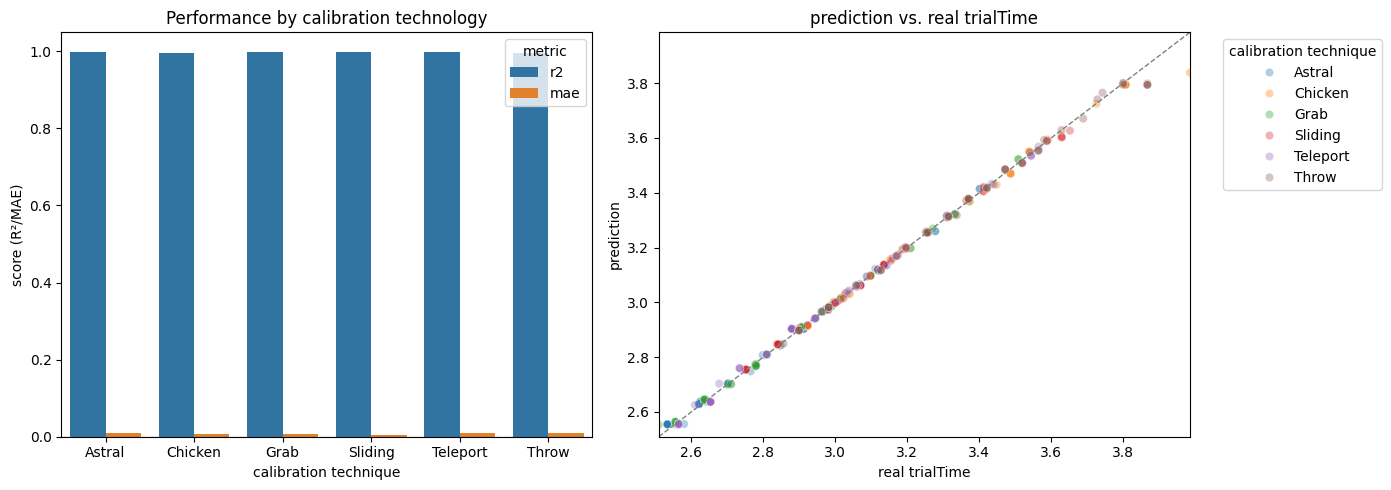

In [342]:
rf_summary_melt = rf_summary.melt(id_vars="calibration", value_vars=["r2", "mae"], var_name="metric")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=rf_summary_melt, x="calibration", y="value", hue="metric", ax=axes[0])
axes[0].set_title("Performance by calibration technology")
axes[0].set_ylabel("score (R²/MAE)")
axes[0].set_xlabel("calibration technique")
axes[0].axhline(0, color="gray", linewidth=1, linestyle="--", alpha=0.6)
axes[0].legend(title="metric")

rf_predictions["abs_error"] = (rf_predictions["predicted"] - rf_predictions["actual"]).abs()
lims = [
    min(rf_predictions["actual"].min(), rf_predictions["predicted"].min()),
    max(rf_predictions["actual"].max(), rf_predictions["predicted"].max()),
]

sns.scatterplot(
    data=rf_predictions,
    x="actual",
    y="predicted",
    hue="calibration",
    alpha=0.35,
    ax=axes[1],
)
axes[1].plot(lims, lims, linestyle="--", color="gray", linewidth=1)
axes[1].set_xlim(lims)
axes[1].set_ylim(lims)
axes[1].set_title("prediction vs. real trialTime")
axes[1].set_xlabel("real trialTime")
axes[1].set_ylabel("prediction")
axes[1].legend(title="calibration technique", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


## Elastic Net Regression for comparison
- Same hold-out scheme: train on the other five techniques, test on the calibration/hold-out technique.
- Numeric features: median impute + standardize; categorical: mode impute + one-hot encode.
- Hyperparameters searched with `GridSearchCV(cv=3)`: multiple `alpha` and `l1_ratio` combinations; record R² and MAE per calibration.
- Keep per-row predictions for plotting.

In [343]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

enet_results = []
enet_prediction_rows = []
enet_cv_rows = []

alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0]
l1_grid = [0.1, 0.3, 0.5, 0.7, 0.9]

for calibration_tech in techniques:
    train_df = clean_df[clean_df["technique"] != calibration_tech].dropna(subset=[target_col])
    test_df = clean_df[clean_df["technique"] == calibration_tech].dropna(subset=[target_col])
    usable_cols = [c for c in base_feature_cols if not train_df[c].isna().all()]
    X_train = train_df[usable_cols].copy()
    X_test = test_df[usable_cols].copy()
    y_train = train_df[target_col]
    cv_splits = get_stratified_cv(y_train, n_splits=3)
    y_test = test_df[target_col]

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    preprocessor = ColumnTransformer(
        [
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore")),
                    ]
                ),
                categorical_cols,
            ),
        ]
    )

    enet = ElasticNet(max_iter=5000, random_state=42)
    param_grid = {"reg__alpha": alpha_grid, "reg__l1_ratio": l1_grid}
    model = Pipeline([("prep", preprocessor), ("reg", enet)])
    search = GridSearchCV(model, param_grid=param_grid, cv=cv_splits, n_jobs=-1)
    search.fit(X_train, y_train)
    preds = search.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    enet_results.append(
        {
            "calibration": calibration_tech,
            "r2": r2,
            "mae": mae,
            "best_alpha": search.best_params_["reg__alpha"],
            "best_l1_ratio": search.best_params_["reg__l1_ratio"],
        }
    )

    cv_df = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv_df.columns if c.startswith("param_")]
    enet_cv_rows.append(cv_df[param_cols + ["mean_test_score"]].assign(calibration=calibration_tech))

    enet_prediction_rows.append(
        pd.DataFrame(
            {
                "calibration": calibration_tech,
                "technique": test_df["technique"].values,
                "iD": test_df["iD"].values,
                "actual": y_test.values,
                "predicted": preds,
            }
        )
    )

enet_summary = pd.DataFrame(enet_results).sort_values("calibration").reset_index(drop=True)
enet_predictions = pd.concat(enet_prediction_rows, ignore_index=True)
enet_cv_results = pd.concat(enet_cv_rows, ignore_index=True).assign(model="Elastic Net")

print("Calibration hold-out Elastic Net with CV (train on other five techniques):")
display(enet_summary)
print("Prediction sample:")
display(enet_predictions.head())


Calibration hold-out Elastic Net with CV (train on other five techniques):


,calibration,r2,mae,best_alpha,best_l1_ratio
0,Astral,0.804213,0.077929,0.001,0.7
1,Chicken,0.924291,0.043152,0.001,0.9
2,Grab,0.912823,0.059157,0.001,0.9
3,Sliding,0.953200,0.041623,0.001,0.9
4,Teleport,0.939742,0.056111,0.010,0.3
5,Throw,0.825754,0.111457,0.001,0.9


Prediction sample:


,calibration,technique,iD,actual,predicted
0,Astral,Astral,P001,2.621766,2.650108
1,Astral,Astral,P002,2.533697,2.728827
2,Astral,Astral,P003,2.912351,2.966465
3,Astral,Astral,P004,2.847232,2.923446
4,Astral,Astral,P005,2.777576,2.842373


## Support Vector Regression (SVR)
- Hold-out scheme: train on the other five techniques, test on the calibration technique.
- Preprocess: median-impute + standardize numeric; mode-impute + one-hot encode categorical (dense) to support SVR.
- Hyperparameter grid (cv=3): `C`, `epsilon`, `gamma`, `kernel`; record R²/MAE and best params; keep predictions.

In [344]:
from sklearn.svm import SVR

svr_param_grid = {
    "reg__C": [1, 10, 100],
    "reg__epsilon": [0.1, 0.3, 0.5],
    "reg__gamma": ["scale", "auto"],
    "reg__kernel": ["rbf", "poly"],
}

svr_results = []
svr_prediction_rows = []
svr_cv_rows = []

for calibration_tech in techniques:
    train_df = clean_df[clean_df["technique"] != calibration_tech].dropna(subset=[target_col])
    test_df = clean_df[clean_df["technique"] == calibration_tech].dropna(subset=[target_col])

    usable_cols = [c for c in base_feature_cols if not train_df[c].isna().all()]
    X_train = train_df[usable_cols].copy()
    X_test = test_df[usable_cols].copy()
    y_train = train_df[target_col]
    cv_splits = get_stratified_cv(y_train, n_splits=3)
    y_test = test_df[target_col]

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    preprocessor = ColumnTransformer(
        [
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
                    ]
                ),
                categorical_cols,
            ),
        ]
    )

    svr = SVR()
    model = Pipeline([("prep", preprocessor), ("reg", svr)])
    search = GridSearchCV(model, param_grid=svr_param_grid, cv=cv_splits, n_jobs=-1)
    search.fit(X_train, y_train)
    preds = search.predict(X_test)

    best_params = search.best_params_
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    svr_results.append(
        {
            "calibration": calibration_tech,
            "r2": r2,
            "mae": mae,
            "best_kernel": best_params["reg__kernel"],
            "best_C": best_params["reg__C"],
            "best_epsilon": best_params["reg__epsilon"],
            "best_gamma": best_params["reg__gamma"],
        }
    )

    cv_df = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv_df.columns if c.startswith("param_")]
    svr_cv_rows.append(cv_df[param_cols + ["mean_test_score"]].assign(calibration=calibration_tech))

    svr_prediction_rows.append(
        pd.DataFrame(
            {
                "calibration": calibration_tech,
                "technique": test_df["technique"].values,
                "iD": test_df["iD"].values,
                "actual": y_test.values,
                "predicted": preds,
            }
        )
    )

svr_summary = pd.DataFrame(svr_results).sort_values("calibration").reset_index(drop=True)
svr_predictions = pd.concat(svr_prediction_rows, ignore_index=True)
svr_cv_results = pd.concat(svr_cv_rows, ignore_index=True).assign(model="SVR")

print("Calibration hold-out SVR with CV:")
display(svr_summary)
print("Prediction sample:")
display(svr_predictions.head())


/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoder

Calibration hold-out SVR with CV:


/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoder

,calibration,r2,mae,best_kernel,best_C,best_epsilon,best_gamma
0,Astral,-1.957546,0.321355,rbf,10,0.1,auto
1,Chicken,0.110237,0.175009,rbf,10,0.1,auto
2,Grab,0.606496,0.129160,rbf,10,0.1,auto
3,Sliding,0.903465,0.059234,rbf,10,0.1,auto
4,Teleport,0.861557,0.080955,rbf,10,0.1,auto
5,Throw,-1.235810,0.352964,rbf,10,0.1,auto


Prediction sample:


,calibration,technique,iD,actual,predicted
0,Astral,Astral,P001,2.621766,3.106764
1,Astral,Astral,P002,2.533697,3.106758
2,Astral,Astral,P003,2.912351,3.106763
3,Astral,Astral,P004,2.847232,3.106762
4,Astral,Astral,P005,2.777576,3.106682


## Gaussian Process Regression (GPR)
- Hold-out scheme: train on the other five techniques, test on the calibration technique.
- Preprocess: median-impute + standardize numeric; mode-impute + one-hot encode categorical (dense) for kernel methods.
- GridSearchCV (cv=3) over a few kernels and alpha values; pick the best on training folds, then evaluate on the hold-out; record R²/MAE and best params; keep predictions.

In [345]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

gpr_results = []
gpr_prediction_rows = []
gpr_cv_rows = []

gpr_kernels = [
    ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0),
    ConstantKernel(1.0) * RBF(length_scale=2.0) + WhiteKernel(noise_level=0.5),
]
gpr_alphas = [1e-2, 1e-3]

param_grid = {"reg__kernel": gpr_kernels, "reg__alpha": gpr_alphas}

for calibration_tech in techniques:
    train_df = clean_df[clean_df["technique"] != calibration_tech].dropna(subset=[target_col])
    test_df = clean_df[clean_df["technique"] == calibration_tech].dropna(subset=[target_col])

    usable_cols = [c for c in base_feature_cols if not train_df[c].isna().all()]
    X_train = train_df[usable_cols].copy()
    X_test = test_df[usable_cols].copy()
    y_train = train_df[target_col]
    cv_splits = get_stratified_cv(y_train, n_splits=3)
    y_test = test_df[target_col]

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    preprocessor = ColumnTransformer(
        [
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
                    ]
                ),
                categorical_cols,
            ),
        ]
    )

    base_gpr = GaussianProcessRegressor(normalize_y=True, random_state=42)
    model = Pipeline([("prep", preprocessor), ("reg", base_gpr)])
    search = GridSearchCV(model, param_grid=param_grid, cv=cv_splits, n_jobs=-1)
    search.fit(X_train, y_train)
    preds = search.predict(X_test)

    best_params = search.best_params_
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    gpr_results.append(
        {
            "calibration": calibration_tech,
            "r2": r2,
            "mae": mae,
            "best_kernel": str(best_params["reg__kernel"]),
            "best_alpha": best_params["reg__alpha"],
        }
    )

    cv_df = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv_df.columns if c.startswith("param_")]
    gpr_cv_rows.append(cv_df[param_cols + ["mean_test_score"]].assign(calibration=calibration_tech))

    gpr_prediction_rows.append(
        pd.DataFrame(
            {
                "calibration": calibration_tech,
                "technique": test_df["technique"].values,
                "iD": test_df["iD"].values,
                "actual": y_test.values,
                "predicted": preds,
            }
        )
    )

gpr_summary = pd.DataFrame(gpr_results).sort_values("calibration").reset_index(drop=True)
gpr_predictions = pd.concat(gpr_prediction_rows, ignore_index=True)
gpr_cv_results = pd.concat(gpr_cv_rows, ignore_index=True).assign(model="GPR")

print("Calibration hold-out GPR with CV:")
display(gpr_summary)
print("Prediction sample:")
display(gpr_predictions.head())


/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/preprocessing/_encoder

Calibration hold-out GPR with CV:


/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,calibration,r2,mae,best_kernel,best_alpha
0,Astral,-0.844355,0.244395,1**2 * RBF(length_scale=2) + WhiteKernel(noise...,0.001
1,Chicken,0.967301,0.040232,1**2 * RBF(length_scale=2) + WhiteKernel(noise...,0.001
2,Grab,0.973351,0.031827,1**2 * RBF(length_scale=2) + WhiteKernel(noise...,0.001
3,Sliding,0.985130,0.023083,1**2 * RBF(length_scale=1) + WhiteKernel(noise...,0.001
4,Teleport,0.988807,0.020907,1**2 * RBF(length_scale=2) + WhiteKernel(noise...,0.001
5,Throw,-0.132052,0.269295,1**2 * RBF(length_scale=2) + WhiteKernel(noise...,0.001


Prediction sample:


,calibration,technique,iD,actual,predicted
0,Astral,Astral,P001,2.621766,3.086731
1,Astral,Astral,P002,2.533697,2.884589
2,Astral,Astral,P003,2.912351,3.117790
3,Astral,Astral,P004,2.847232,3.092765
4,Astral,Astral,P005,2.777576,2.970989


## Gradient Boosting (XGBoost / CatBoost)
- Hold-out scheme: train on the other five techniques, test on the calibration technique.
- Preprocess: median-impute numeric; mode-impute + one-hot encode categorical.
- Primary: try XGBoost grid; fallback to CatBoost grid; if neither library is installed, fall back to sklearn GradientBoostingRegressor with a smaller grid. All runs use `GridSearchCV(cv=3)`; record best params, R²/MAE, and predictions.

In [346]:
boost_results = []
boost_prediction_rows = []
boost_cv_rows = []

try:
    from xgboost import XGBRegressor

    boost_model_name = "XGBoost"
    base_reg = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="rmse",
    )
    boost_param_grid = {
        "reg__n_estimators": [200, 400, 800],
        "reg__max_depth": [3, 5, 7],
        "reg__learning_rate": [0.03, 0.1],
        "reg__subsample": [0.8, 1.0],
        "reg__colsample_bytree": [0.8, 1.0],
    }
except ImportError:
    try:
        from catboost import CatBoostRegressor

        boost_model_name = "CatBoost"
        base_reg = CatBoostRegressor(loss_function="RMSE", random_seed=42, verbose=False)
        boost_param_grid = {
            "reg__iterations": [300, 600],
            "reg__depth": [4, 6, 8],
            "reg__learning_rate": [0.03, 0.1],
            "reg__l2_leaf_reg": [1, 3, 5],
        }
    except ImportError:
        from sklearn.ensemble import GradientBoostingRegressor
        boost_model_name = "Sklearn GBT"
        base_reg = GradientBoostingRegressor(random_state=42)
        boost_param_grid = {
            "reg__n_estimators": [200, 400],
            "reg__learning_rate": [0.03, 0.1],
            "reg__max_depth": [3, 5],
            "reg__subsample": [0.8, 1.0],
        }

for calibration_tech in techniques:
    train_df = clean_df[clean_df["technique"] != calibration_tech].dropna(subset=[target_col])
    test_df = clean_df[clean_df["technique"] == calibration_tech].dropna(subset=[target_col])

    usable_cols = [c for c in base_feature_cols if not train_df[c].isna().all()]
    X_train = train_df[usable_cols].copy()
    X_test = test_df[usable_cols].copy()
    y_train = train_df[target_col]
    cv_splits = get_stratified_cv(y_train, n_splits=3)
    y_test = test_df[target_col]

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    preprocessor = ColumnTransformer(
        [
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore")),
                    ]
                ),
                categorical_cols,
            ),
        ]
    )

    model = Pipeline([("prep", preprocessor), ("reg", base_reg)])
    search = GridSearchCV(model, param_grid=boost_param_grid, cv=cv_splits, n_jobs=-1)
    search.fit(X_train, y_train)
    preds = search.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    boost_results.append(
        {
            "calibration": calibration_tech,
            "r2": r2,
            "mae": mae,
            "best_params": search.best_params_,
            "model_name": boost_model_name,
        }
    )

    cv_df = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv_df.columns if c.startswith("param_")]
    boost_cv_rows.append(cv_df[param_cols + ["mean_test_score"]].assign(calibration=calibration_tech, model=boost_model_name))

    boost_prediction_rows.append(
        pd.DataFrame(
            {
                "calibration": calibration_tech,
                "technique": test_df["technique"].values,
                "iD": test_df["iD"].values,
                "actual": y_test.values,
                "predicted": preds,
            }
        )
    )

boost_summary = pd.DataFrame(boost_results).sort_values("calibration").reset_index(drop=True)
boost_predictions = pd.concat(boost_prediction_rows, ignore_index=True)
boost_cv_results = pd.concat(boost_cv_rows, ignore_index=True).assign(model=boost_model_name)

print(f"Calibration hold-out {boost_model_name} with CV:")
display(boost_summary)
print("Prediction sample:")
display(boost_predictions.head())


Calibration hold-out Sklearn GBT with CV:


,calibration,r2,mae,best_params,model_name
0,Astral,0.996623,0.007641,"{'reg__learning_rate': 0.03, 'reg__max_depth':...",Sklearn GBT
1,Chicken,0.996757,0.004004,"{'reg__learning_rate': 0.03, 'reg__max_depth':...",Sklearn GBT
2,Grab,0.999567,0.003161,"{'reg__learning_rate': 0.03, 'reg__max_depth':...",Sklearn GBT
3,Sliding,0.999342,0.004396,"{'reg__learning_rate': 0.1, 'reg__max_depth': ...",Sklearn GBT
4,Teleport,0.998721,0.006953,"{'reg__learning_rate': 0.03, 'reg__max_depth':...",Sklearn GBT
5,Throw,0.996899,0.007948,"{'reg__learning_rate': 0.03, 'reg__max_depth':...",Sklearn GBT


Prediction sample:


,calibration,technique,iD,actual,predicted
0,Astral,Astral,P001,2.621766,2.589772
1,Astral,Astral,P002,2.533697,2.532980
2,Astral,Astral,P003,2.912351,2.906907
3,Astral,Astral,P004,2.847232,2.845019
4,Astral,Astral,P005,2.777576,2.773219


### Model comparison plots (all models)
- Bar charts: R² and MAE per calibration technique across Random Forest, Elastic Net, SVR, GPR, and XGBoost/CatBoost.
- Scatter plots: predicted vs. actual `trialTime`, faceted by model; legend shows calibration technique.

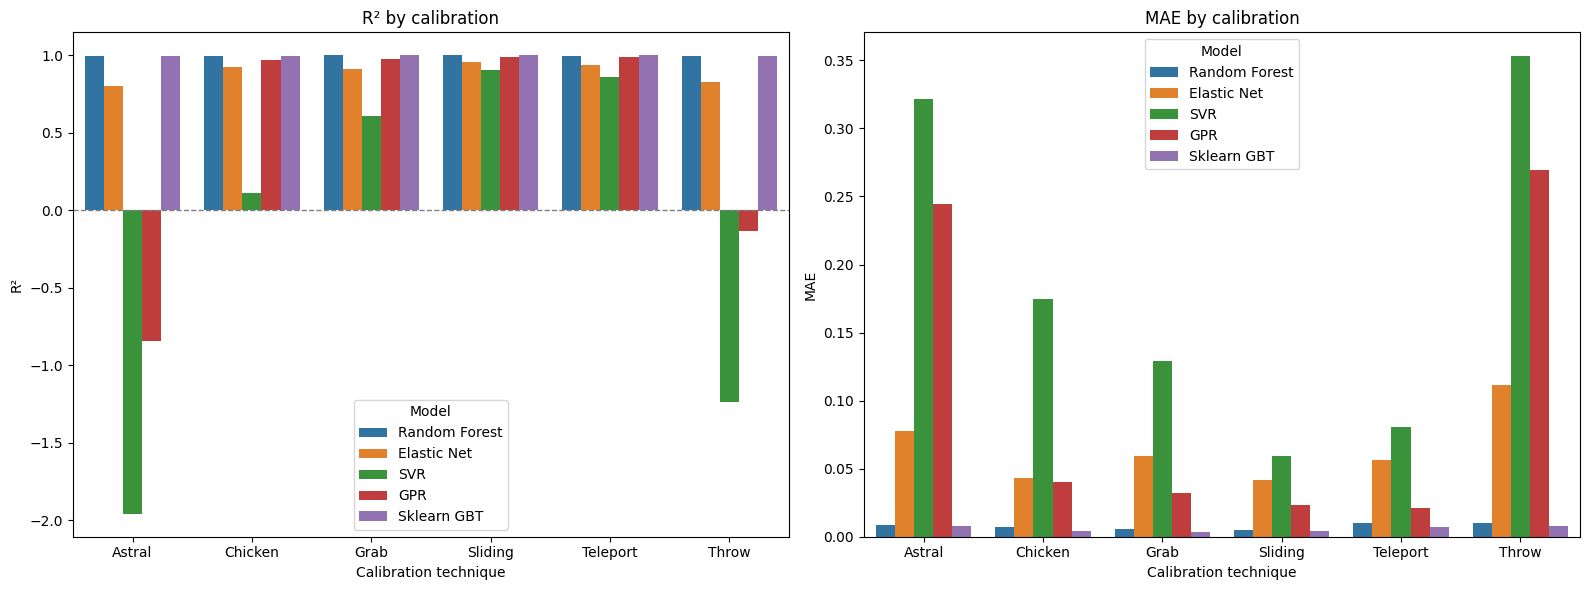

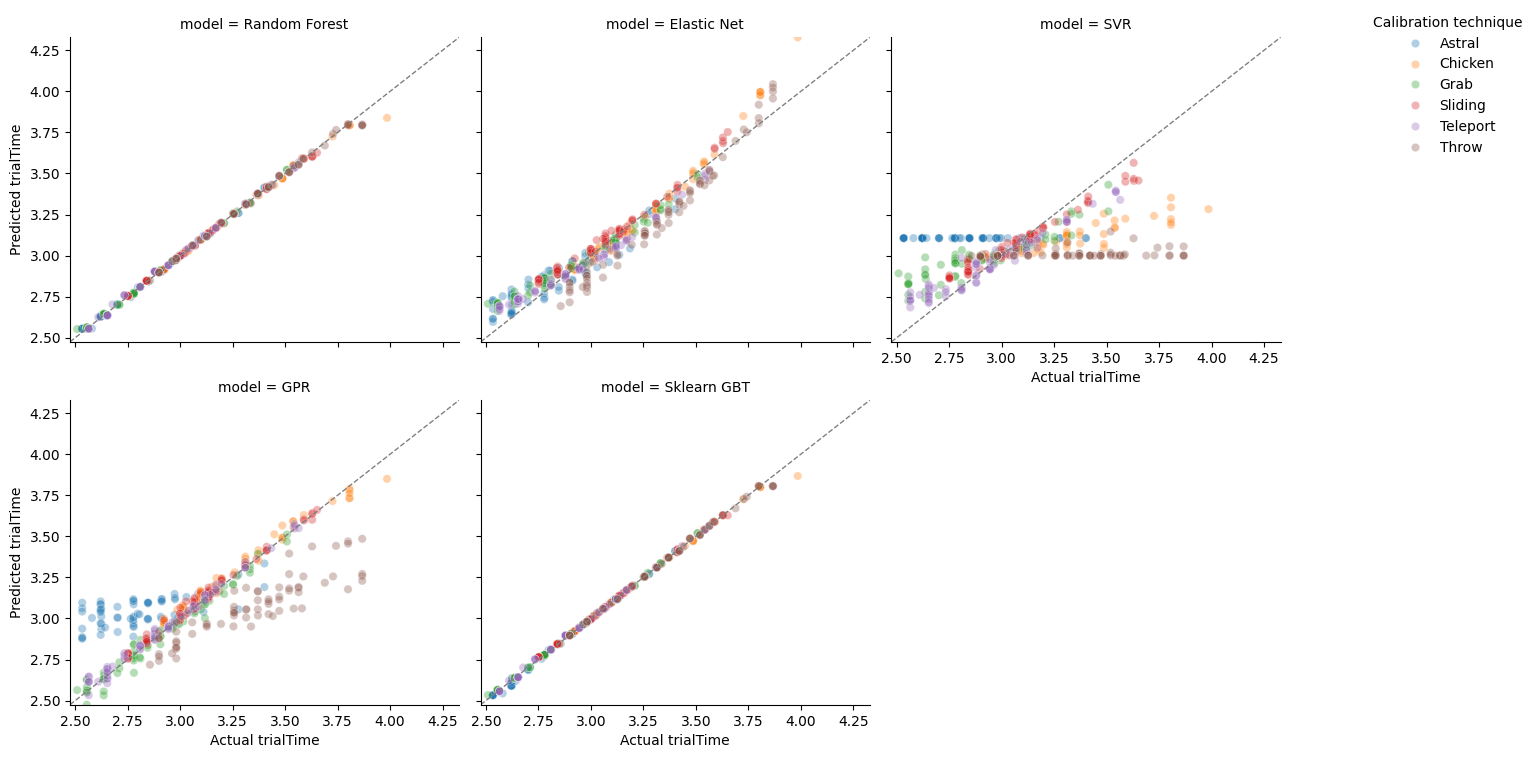

In [347]:
combined_summary = pd.concat([
    rf_summary.assign(model="Random Forest"),
    enet_summary.assign(model="Elastic Net"),
    svr_summary.assign(model="SVR"),
    gpr_summary.assign(model="GPR"),
    boost_summary.assign(model=boost_model_name),
], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=combined_summary, x="calibration", y="r2", hue="model", ax=axes[0])
axes[0].set_title("R² by calibration")
axes[0].set_ylabel("R²")
axes[0].set_xlabel("Calibration technique")
axes[0].axhline(0, color="gray", linestyle="--", linewidth=1)
axes[0].legend(title="Model")

sns.barplot(data=combined_summary, x="calibration", y="mae", hue="model", ax=axes[1])
axes[1].set_title("MAE by calibration")
axes[1].set_ylabel("MAE")
axes[1].set_xlabel("Calibration technique")
axes[1].legend(title="Model")
plt.tight_layout()
plt.show()

rf_predictions["model"] = "Random Forest"
enet_predictions["model"] = "Elastic Net"
svr_predictions["model"] = "SVR"
gpr_predictions["model"] = "GPR"
boost_predictions["model"] = boost_model_name
combined_predictions = pd.concat(
    [rf_predictions, enet_predictions, svr_predictions, gpr_predictions, boost_predictions],
    ignore_index=True,
)

lims = [
    min(combined_predictions["actual"].min(), combined_predictions["predicted"].min()),
    max(combined_predictions["actual"].max(), combined_predictions["predicted"].max()),
]

g = sns.FacetGrid(combined_predictions, col="model", col_wrap=3, sharex=True, sharey=True, height=3.8)
g.map_dataframe(sns.scatterplot, x="actual", y="predicted", hue="calibration", alpha=0.35)
for ax in g.axes.flatten():
    ax.plot(lims, lims, linestyle="--", color="gray", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel("Actual trialTime")
    ax.set_ylabel("Predicted trialTime")
g.add_legend(title="Calibration technique", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Additional comparison visuals
- Overall model comparison: average R² / MAE across all calibration hold-outs.
- Hyperparameter comparison: mean CV score by hyperparameter combination for each model (top combos).
- Existing per-calibration bars and scatter plots remain for calibration-level comparisons.

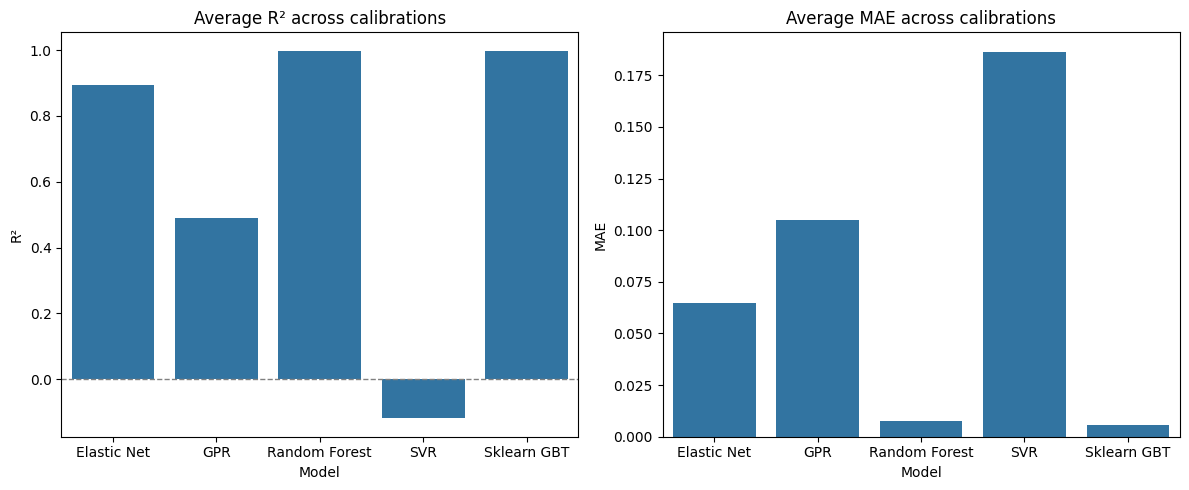

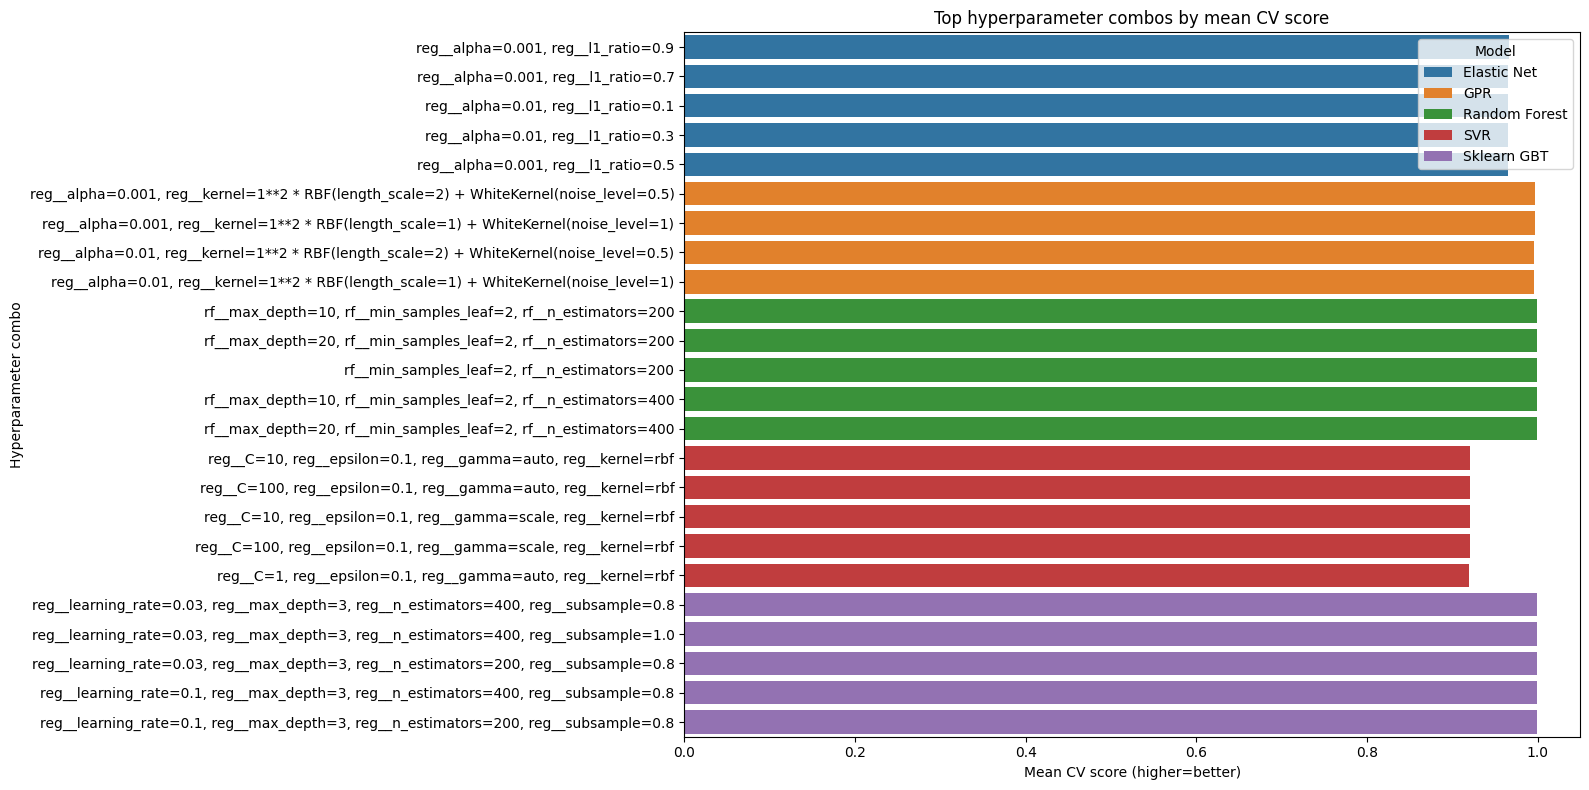

In [348]:

# Aggregate model-level averages
model_means = combined_summary.groupby("model")[['r2', 'mae']].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=model_means, x="model", y="r2", ax=axes[0])
axes[0].set_title("Average R² across calibrations")
axes[0].axhline(0, color="gray", linestyle="--", linewidth=1)
axes[0].set_ylabel("R²")
axes[0].set_xlabel("Model")

sns.barplot(data=model_means, x="model", y="mae", ax=axes[1])
axes[1].set_title("Average MAE across calibrations")
axes[1].set_ylabel("MAE")
axes[1].set_xlabel("Model")
plt.tight_layout()
plt.show()

# Combine CV results across models
cv_frames = [rf_cv_results, enet_cv_results, svr_cv_results, gpr_cv_results, boost_cv_results]
cv_results_all = pd.concat(cv_frames, ignore_index=True)
param_cols = [c for c in cv_results_all.columns if c.startswith("param_")]
cv_results_all["param_combo"] = cv_results_all[param_cols].apply(
    lambda row: ", ".join(
        f"{c.replace('param_', '')}={row[c]}" for c in param_cols if pd.notna(row[c])
    ),
    axis=1,
)

cv_param_mean = (
    cv_results_all.groupby(["model", "param_combo"])['mean_test_score']
    .mean()
    .reset_index()
)
# keep top 5 combos per model
cv_top = cv_param_mean.sort_values(["model", "mean_test_score"], ascending=[True, False])
cv_top = cv_top.groupby("model").head(5)

plt.figure(figsize=(16, 8))
sns.barplot(data=cv_top, x="mean_test_score", y="param_combo", hue="model")
plt.title("Top hyperparameter combos by mean CV score")
plt.xlabel("Mean CV score (higher=better)")
plt.ylabel("Hyperparameter combo")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


In [349]:
# Random split baseline (mixed techniques)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

mixed_df = clean_df.dropna(subset=[target_col_name]).copy()

mixed_base_features = select_base_features(mixed_df, target_col_name)
usable_cols = [c for c in mixed_base_features if not mixed_df[c].isna().all()]
X = mixed_df[usable_cols].copy()
y = mixed_df[target_col_name]

# Stratify the train/test split with binned target to preserve distribution
bins = pd.qcut(y, q=min(5, len(y)), duplicates='drop').astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=bins
)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

preprocessor = ColumnTransformer(
    [
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_cols,
        ),
    ]
)

rf_param_grid = {
    "rf__n_estimators": [200, 400, 800],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
}

rf = RandomForestRegressor(random_state=42)
model = Pipeline([("prep", preprocessor), ("rf", rf)])
cv_splits = get_stratified_cv(y_train, n_splits=3)
search = GridSearchCV(model, param_grid=rf_param_grid, cv=cv_splits, n_jobs=-1)
search.fit(X_train, y_train)
test_preds = search.predict(X_test)

baseline_r2 = r2_score(y_test, test_preds)
baseline_mae = mean_absolute_error(y_test, test_preds)

print("Random split baseline (mixed techniques):")
print(f"Test R2: {baseline_r2:.3f}, Test MAE: {baseline_mae:.3f}")
print("Best params:", search.best_params_)

fi_df = extract_feature_importances(search, "rf")
if fi_df is not None:
    print("Top RF feature importances (mixed split):")
    display(fi_df.head(20))


Random split baseline (mixed techniques):
Test R2: 1.000, Test MAE: 0.003
Best params: {'rf__max_depth': None, 'rf__max_features': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 400}
Top RF feature importances (mixed split):


,feature,importance
0,num__trialTime,0.999193
1,num__axisCrossedCount,0.000096
2,num__headTotalDistance,0.000072
3,num__headExtent,0.000061
4,num__buttonPressCount,0.000047
5,num__movementVariability,0.000042
6,num__rightTriggerPressure,0.000037
7,num__rightExtent,0.000037
8,num__leftHeadDistance,0.000035
9,num__trialBlock,0.000035
